<p style="color:#008bcb; font-family:Arial; font-size:19px;"> Notebook Information </p>

<table style="color:rgb(88,89,91); font-family:Arial; float:left; font-size:13px; text-align:left;">
<tr>
<td style="color:#008BCB;font-size:13px; text-align:left;"><b>Report</b></td>
<td style="text-align:left;">Exploratory Data Analysis and Automated ETL pipeline for PowerBI Audit Log </td>
</tr>
<tr>
<td style="color:#008BCB;font-size:13px; text-align:left;"><b>Author</b></td>
<td style="text-align:left;">Sanmi Ibitoye</td>
</tr>
<tr>
<td style="color:#008BCB;font-size:13px; text-align:left;"><b>Email</b></td>
<td style="text-align:left;">Sanmi.Ibitoye@hs2.org.uk</td>
</tr>
<tr>
<td style="color:#008BCB;font-size:13px; text-align:left;"><b>Summary</b></td>
<td style="text-align:left;">This notebook forms the basis of all future etl, tools and infrastructure doployable in relation to PowerBI Audit Log Report project. <br>
Initial analysis and exploration helps unearth the data so that its shape, format and condition is understood by team memebers and explainable to stakeholders. <br>
The resulting pipelines and infrastructure will employ the use of technology stacks such as git, postgres, docker, dbt, bespoke python libraries, airbyte and <br> prefect for automation, ochestration and compute. Alternative stack could also be implemented<br>
This will serve a powerbi dashboard data for its vizualisation and translation to english for the stakeholder <br>
</td>
</tr>
<tr>
<td style="color:#008BCB;font-size:13px; text-align:left;"><b>Date</b></td>
<td style="text-align:left;">Last Updated: 08 - 12 - 2022 </td>
</tr>

</table>

In [4]:
# Define the required library Imports
try:
    import pandas as pd
    import numpy as np
    from functools import wraps
    import os
    import glob

    import json
    import math

    # import dask
    # from dask.distributed import Client
    # import dask.dataframe as dd
    # import dask.multiprocessing
    import yaml
    import base64

    from IPython.display import display, HTML

    # display(HTML("<style>.container {width:90% !important;}<style/>"))

    # datetime libraries
    import datetime
    from datetime import datetime, timedelta

    from functools import wraps
    from calendar import monthrange
    import datetime as dt
    import time

    # prefect libraries
    from prefect import task, Flow

    # from prefect.schedules import IntervalSchedule

    # plotting libraries
    import seaborn as sns
    import matplotlib.pyplot as plt

    # profiling libraries
    # from pandas_profiling import ProfileReport

    # config libraries
    import hydra
    from omegaconf import DictConfig, OmegaConf
    from hydra import utils


except Exception as e:
    print("Some Modules are Missing : {} ".format(e))

<p style="color:#008bcb; font-family:Arial; font-size:19px;">1 - Turn multiple csv into a single pandas dataframe.</p>
<tr>
<td style="color:#008BCB;font-size:13px; text-align:left;"><b>Note 1.1 </b></td>
<td style="color:rgb(88,89,91);font-size:13px; text-align:left;">The Power BI Activily Log data is extracted using a powershell script that only allows an API call of maximum 30 days from current date. <br>
A single csv file holds the data for each day of selected columns defined in the powershell script. Each day represented by a csv file is stacked into a single pandas dataframe prior to subsequent analysis</td>
</tr>

<tr>
<td style="color:#008BCB;font-size:13px; text-align:left;"><b>Note 1.2 </b></td>
<td style="color:rgb(88,89,91);font-size:13px; text-align:left;">The CSV files are obtained using a shell script. Although atleast 4 methods of interacting with the API exists, the option used in this solution fetches satisfies all possible user requirements known now and any unkown in the future <br>
The 74 columns extracted holds a set of operations, all of which fall within the common activities that 98% of Power BI users will execute.<br> Analysis of the raw data has shown that the other operations which are rare and not relevant to the audit purpose often come through as blanks.</td>
</tr>

<tr>
<td style="color:#008BCB;font-size:13px; text-align:left;"><b>Note 1.3 </b></td>
<td style="color:rgb(88,89,91);font-size:13px; text-align:left;">Using glob.glob works differently on Ubuntu compared to Windows <br>
The file location is passed as a variable so when configuring or debugging, attention should be given to glob.glob pattern that applies to host system</td>
</tr>

<tr>
<td style="color:#008BCB;font-size:13px; text-align:left;">Ref. Bash Script</td>
<td style="color:rgb(88,89,91);font-size:13px; text-align:left;">https://community.powerbi.com/t5/Service/User-activities-by-Powershell/m-p/2071415</td>
</tr>

In [5]:
# import helper from src folder
from mlops_pbi.src.helper import load_config

# load raw files and concat into single data frame using columns defined above as column names for the dataframe to be created.
@hydra.main(config_path="config", config_name="main", version_base="1.2")
def load_raw_files(config: DictConfig) -> pd.DataFrame:
    """
    Load raw files and concat into single data frame using columns defined above as column names for the dataframe to be created.
    """
    all_df = pd.concat(
        [
            pd.read_csv(
                one_filename,
                low_memory=config.raw_data.low_memory,
                header=config.raw_data.header,
                sep=config.raw_data.separator,
                encoding=config.raw_data.encoding,
                names=config.raw_data.names,
            )
            for one_filename in glob.glob(config.raw_data.path)
        ]
    )

    return all_df


# assign function to a variable and loads dataframe into memory for subsequent analysis with the specified columns

config = load_config()
df = load_raw_files(config)

# df.columns = columns

In [6]:
df.head()

,Id,CreationTime,CreationTimeUTC,RecordType,Operation,OrganizationId,UserType,UserKey,Workload,UserId,...,CapacityName,AppName,IsSuccess,ReportType,RequestId,ActivityId,AppReportId,DistributionMethod,ConsumptionMethod,RetrieveDate
0,5dc2f0de-55e5-4b9b-a148-4e0b8da61b0f,2022-07-30T02:17:41Z,NaN,20,ViewReport,efe042fe-c4cf-4e6b-a8d4-23234c69c5ec,0,10032000AC2F9770,PowerBI,gerardlewis@example.net,...,NaN,NaN,True,PowerBIReport,5e99a25f-6805-44be-9631-0063b9f3d976,08d9116f-70c7-4f07-9b21-c2350656a645,NaN,Shared,Power BI Web,30/07/2022 10:45:59
1,0c6c5fdc-71b3-421d-b65a-0dcdb90116eb,2022-07-30T02:02:45Z,NaN,20,ViewReport,efe042fe-c4cf-4e6b-a8d4-23234c69c5ec,0,10032000EF9A6A01,PowerBI,molly64@example.net,...,NaN,NaN,True,PowerBIReport,1c987f5b-d0ed-43b8-acce-0d10d46f9929,49a0343f-52eb-471c-98ee-a2477d0d4c42,NaN,Shared,Power BI Web,30/07/2022 10:45:59
2,f558ca6f-792a-4eeb-85eb-4b4abf4f5ec9,2022-07-30T04:10:29Z,NaN,20,ViewReport,efe042fe-c4cf-4e6b-a8d4-23234c69c5ec,0,10032000F7444DFF,PowerBI,emily68@example.org,...,NaN,NaN,True,PowerBIReport,ffdba523-62d6-b9d2-6c82-8f87f4a0e0d4,9bb026b0-07d2-44fe-61b2-38cb47784408,NaN,Shared,Power BI Web,30/07/2022 10:45:59
3,e713e41c-7ac6-42ae-a2c5-691eab33a60a,2022-07-30T04:30:38Z,NaN,20,ViewReport,efe042fe-c4cf-4e6b-a8d4-23234c69c5ec,0,10030000AEDA3393,PowerBI,rowelinda@example.net,...,NaN,NaN,True,PowerBIReport,b3474fd7-e049-4149-b59e-46d1805848e0,e6588b92-9109-472f-bfbe-deba26f5e6d3,NaN,Workspace,Power BI Web,30/07/2022 10:45:59
4,a43939d8-b525-4c0d-9d3c-0cea196a981a,2022-07-30T04:10:12Z,NaN,20,ViewReport,efe042fe-c4cf-4e6b-a8d4-23234c69c5ec,0,10032000F7444DFF,PowerBI,emily68@example.org,...,NaN,NaN,True,PowerBIReport,cad7d391-c11c-49b9-b45e-3fa97c7044b6,6816bfd0-0fd6-4d5b-ba09-6915e3efda93,NaN,Shared,Power BI Web,30/07/2022 10:45:59


In [7]:
# optional - save dataframe to csv
# df_raw_profile = ProfileReport(df, title="PowerBI AuditLog Raw Data Profiling Report", explorative=True)
# df_raw_profile.to_file("df_raw_profile.html")

<p style="color:#008bcb; font-family:Arial; font-size:19px;">2 - Run transformation pipeline on multiple csv concatenated into a single pandas dataframe.</p>
<tr>
<td style="color:#008BCB;font-size:13px; text-align:left;"><b>Note 2.1 </b></td>
<td style="color:rgb(88,89,91);font-size:13px; text-align:left;">The Power BI Activily Log data extracted using a powershell script has now been concatenated into a single dataframe. <br>
A single dataframe holds all the data in memory. The tansformation pipeline makes a copy of the dataframe to avoid mutations on the original copy. <br> The pipeline is then run on the copy of the dataframe and the original dataframe is left untouched. <br> Date columns are converted to datetime format. <br> The datetime column is used to extract the month, year and day.
</td>
</td>
</td>
</tr>

<tr>
<td style="color:#008BCB;font-size:13px; text-align:left;"><b>Note 2.2 </b></td>
<td style="color:rgb(88,89,91);font-size:13px; text-align:left;">The raw data contains logs that relate to the service account used to fetch the data. These logs skew the data and don't represent a user's activity. <br> As such, the last step in the initial transformation is to filter such logs out. <br> The service account API calls are logged with a unique reference of multiple 0 values. This values is passed as a parameter for the filtering out of all logs not related to an actual user. <br>
The 36 columns extracted holds a set of operations, all of which fall within the common activities that 98% of Power BI users will execute.<br> Analysis of the raw data has shown that the other operations which are rare and not relevant to the audit purpose often come through as blanks.</td>
</tr>

<tr>
<td style="color:#008BCB;font-size:13px; text-align:left;"><b>Note 2.3 </b></td>
<td style="color:rgb(88,89,91);font-size:13px; text-align:left;">This first node in the pipeline is stored as variable "use_df" <br>
</td>
</tr>

<tr>
<td style="color:#008BCB;font-size:13px; text-align:left;">Ref. Bash Script</td>
<td style="color:rgb(88,89,91);font-size:13px; text-align:left;">https://community.powerbi.com/t5/Service/User-activities-by-Powershell/m-p/2071415</td>
</tr>

In [8]:
# import python functions to build pipeline
from mlops_pbi.src.first_ingestion_point import (
    start_pipeline_pbia,
    format_datatype_dates,
    add_month_year_cols_users,
    api_calls_filtered_out,
    lower_case_cols,
)

In [9]:
# variables for the 4th transformation node i.e. api_calls_filtered_out
service_account = "SA_DAL_PowerBI@hs2.org.uk"
operation = "ExportActivityEvents"


use_df = (
    df.pipe(start_pipeline_pbia)
    .pipe(format_datatype_dates)
    .pipe(add_month_year_cols_users)
    .pipe(api_calls_filtered_out, service_account, operation)
    .pipe(lower_case_cols, "UserId", "ReportName")
)

# singleUserLogic = use_df.pipe()

just ran step start_pipeline_pbia shape=(58187, 35) took 0:00:00.027571s
just ran step format_datatype_dates shape=(58187, 35) took 0:00:11.812737s
just ran step add_month_year_cols_users shape=(58187, 38) took 0:00:00.016716s
just ran step api_calls_filtered_out shape=(36067, 38) took 0:00:00.009680s
just ran step lower_case_cols shape=(36067, 38) took 0:00:00.014171s


<p style="color:#008bcb; font-family:Arial; font-size:19px;">3 - Run transformation pipeline on fist node i.e. use_df.</p>
<tr>
<td style="color:#008BCB;font-size:13px; text-align:left;"><b>Note 3.1 </b></td>
<td style="color:rgb(88,89,91);font-size:13px; text-align:left;">This second node in the transformation pipeline extracts useful features for better understanding of the data and machine learning experiments <br> The second node adds new columns to the data set. These columns make it possible to information related to one or multiple entities. <br> length of days with activity, length of days since last active, length of days since first active are all new coloumns derived from time delta. <br> These 3 new columns allows a measure of frequency and recency to be 2 extra features added to the dataframe.
</td>
</td>
</td>
</tr>

<tr>
<td style="color:#008BCB;font-size:13px; text-align:left;"><b>Note 3.2 </b></td>
<td style="color:rgb(88,89,91);font-size:13px; text-align:left;">
The second node ends the transformation pipeline. The dataframe is now ready for analysis and machine learning experiments. The output of both nodes are extracted as csv files. <br> This csv file forms the source data for the unsupervised machine learning process used to cluster the users into 4 quadrants.  <br>
</td>
</tr>

<tr>
<td style="color:#008BCB;font-size:13px; text-align:left;"><b>Note 3.3 </b></td>
<td style="color:rgb(88,89,91);font-size:13px; text-align:left;">The second node is stored as variable "use_df_2" <br>
</td>
</tr>

<tr>
<td style="color:#008BCB;font-size:13px; text-align:left;">Ref. Bash Script</td>
<td style="color:rgb(88,89,91);font-size:13px; text-align:left;">https://community.powerbi.com/t5/Service/User-activities-by-Powershell/m-p/2071415</td>
</tr>

In [10]:
use_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36067 entries, 0 to 455
Data columns (total 38 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   Id                  36067 non-null  object             
 1   CreationTime        36067 non-null  datetime64[ns, UTC]
 2   CreationTimeUTC     0 non-null      datetime64[ns]     
 3   RecordType          36067 non-null  int64              
 4   Operation           36067 non-null  object             
 5   OrganizationId      36067 non-null  object             
 6   UserType            36067 non-null  int64              
 7   UserKey             36067 non-null  object             
 8   Workload            36067 non-null  object             
 9   UserId              36067 non-null  object             
 10  ClientIP            35620 non-null  object             
 11  UserAgent           26906 non-null  object             
 12  Activity            36067 non-null

In [11]:
from mlops_pbi.src.first_ingestion_point import (
    lengthOfDays_since_firstRecord,
    lengthOfDays_since_lastActive,
    lengthOfDays_withActivity,
    single_user_df,
    single_user_frequency,
    percent_time_inactiveFor,
)

In [12]:
use_df_2 = (
    use_df.pipe(single_user_df)
    .pipe(lengthOfDays_withActivity)
    .pipe(lengthOfDays_since_lastActive)
    .pipe(lengthOfDays_since_firstRecord)
    .pipe(single_user_frequency)
    .pipe(percent_time_inactiveFor)
)

just ran step single_user_df shape=(8960, 10) took 0:00:00.023581s
just ran step lengthOfDays_withActivity shape=(8960, 11) took 0:00:00.000853s
just ran step lengthOfDays_since_lastActive shape=(8960, 12) took 0:00:00.000596s
just ran step lengthOfDays_since_firstRecord shape=(8960, 13) took 0:00:00.000573s
just ran step single_user_frequency shape=(8960, 14) took 0:00:00.000572s
just ran step percent_time_inactiveFor shape=(8960, 15) took 0:00:00.000428s


In [13]:
use_df_2

,UserId,UserKey,WorkSpaceName,WorkspaceId,ReportName,ReportId,Activity,count,min,max,lengthOfDays_withActivity,lengthOfDays_since_lastActive,lengthOfDays_since_firstRecord,frequency,%_time_inactiveFor
0,aaron14@example.org,100300009C37523D,kacctydrvl,e1b945e5-9e7d-40f7-a037-8f8d1e5cde79,avezeywxoy,44cda3d5-77a5-45e9-b596-7def26fdab6d,ViewReport,3,2022-07-21 14:33:10+00:00,2022-07-21 15:32:03+00:00,1.0,146.0,146.0,2336.11,99.315
1,aaron14@example.org,100300009C37523D,kacctydrvl,e1b945e5-9e7d-40f7-a037-8f8d1e5cde79,hbtohnbqhf,4d85e424-9af0-4a7f-b874-5f410407f507,ViewReport,2,2022-07-21 07:22:06+00:00,2022-07-21 14:54:07+00:00,1.0,146.0,146.0,5256.25,99.315
2,aaron14@example.org,100300009C37523D,kacctydrvl,e1b945e5-9e7d-40f7-a037-8f8d1e5cde79,mvwgtbbwrh,d8aed01d-d910-4baa-a59e-fb2f2c5047ec,ViewReport,1,2022-07-21 14:32:29+00:00,2022-07-21 14:32:29+00:00,1.0,146.0,146.0,21025.00,99.315
3,aaron14@example.org,100300009C37523D,kacctydrvl,e1b945e5-9e7d-40f7-a037-8f8d1e5cde79,vtlkbzpylz,e621218e-1abf-453a-9856-28900a5fb0fc,ViewReport,1,2022-07-21 13:48:27+00:00,2022-07-21 13:48:27+00:00,1.0,146.0,146.0,21025.00,99.315
4,aaron14@example.org,100300009C37523D,kacctydrvl,e1b945e5-9e7d-40f7-a037-8f8d1e5cde79,yatgdqzkvq,80ffdcac-8e29-421b-a1b3-b06d7ac6dc1c,ViewReport,1,2022-07-21 11:38:31+00:00,2022-07-21 11:38:31+00:00,1.0,146.0,146.0,21025.00,99.315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8955,zthornton@example.net,10032001677F9378,kgymxwezwe,ea6271b3-2f5e-4ae9-a4d2-3173545bc866,ytrozozzfe,0be47813-69b1-45fe-88cb-dfb6730ec2f8,ViewReport,3,2022-08-03 15:48:55+00:00,2022-08-03 15:50:19+00:00,1.0,133.0,133.0,1936.00,99.248
8956,zthornton@example.net,10032001677F9378,wlduqivzst,8dbdee7a-fb8d-4ae7-9a55-061239bd3e1e,umykbutims,80a6e600-3c25-4dfa-aa07-e2c33c063b6a,ViewReport,2,2022-08-03 07:48:50+00:00,2022-08-03 13:38:04+00:00,1.0,133.0,133.0,4356.00,99.248
8957,zturner@example.net,100320008B4C0F6A,lzpitrvjrb,a0fc5ce4-34a6-467a-a4d9-f9bff9acb97f,puzmlablnp,d3ee010a-2e75-4cdc-b6a0-73de84b43c5f,ExportReport,2,2022-09-01 07:10:07+00:00,2022-09-01 09:08:41+00:00,1.0,104.0,104.0,2652.25,99.038
8958,zturner@example.net,100320008B4C0F6A,lzpitrvjrb,a0fc5ce4-34a6-467a-a4d9-f9bff9acb97f,puzmlablnp,d3ee010a-2e75-4cdc-b6a0-73de84b43c5f,ViewReport,1,2022-09-01 07:06:27+00:00,2022-09-01 07:06:27+00:00,1.0,104.0,104.0,10609.00,99.038


In [14]:
from mlops_pbi.src.first_ingestion_point import (
    compare_df_col,
    blank_users_df,
    save_missing_users_df,
)

In [15]:
# compare the 2 dataframes to see if any users are missing from the second node
missing_users_list = compare_df_col(use_df, use_df_2, "UserId")

missing_users_df = blank_users_df(use_df, missing_users_list)

file_path_missing_users = r"C:\Users\sibitoye\Documents\PBI_AuditLog_Final_Python_Output\missing_PBI_Clean_July_August_2022.csv"
save_missing_users_df(df=missing_users_df, path=file_path_missing_users)

In [16]:
# function to save use_df_2 to csv
def save_df_to_csv(df, path):
    df.to_csv(path, index=False)

In [17]:
path_to_saveto = r"C:\Users\sibitoye\Documents\PBI_AuditLog_Final_Python_Output\PBI_Clean_2022.csv"
save_df_to_csv(df=use_df_2, path=path_to_saveto)

In [18]:
use_df_2.describe(include="O", datetime_is_numeric=True).T

,count,unique,top,freq
UserId,8960,4522,jay24@example.org,531
UserKey,8960,576,100320003830C5DD,535
WorkSpaceName,8960,2176,juygpgznkv,128
WorkspaceId,8960,233,8dbdee7a-fb8d-4ae7-9a55-061239bd3e1e,3209
ReportName,8960,4080,amiewznbjs,69
ReportId,8960,833,80a6e600-3c25-4dfa-aa07-e2c33c063b6a,1715
Activity,8960,12,ViewReport,7270


In [19]:
use_df_2.describe(exclude="O", datetime_is_numeric=True).T

,count,mean,min,25%,50%,75%,max,std
count,8960.0,2.215067,1.0,1.0,1.0,2.0,418.0,7.027274
min,8960,2022-08-07 21:41:59.067299072+00:00,2022-07-06 00:02:56+00:00,2022-07-21 11:27:45.249999872+00:00,2022-08-04 12:34:07+00:00,2022-08-25 08:19:01+00:00,2022-09-12 20:12:08+00:00,NaN
max,8960,2022-08-07 22:50:05.426897408+00:00,2022-07-06 03:35:57+00:00,2022-07-21 12:49:25+00:00,2022-08-04 14:29:29+00:00,2022-08-25 09:00:15.500000+00:00,2022-09-12 20:38:18+00:00,NaN
lengthOfDays_withActivity,8960.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
lengthOfDays_since_lastActive,8960.0,128.528125,92.0,111.0,132.0,146.0,161.0,19.88917
lengthOfDays_since_firstRecord,8960.0,128.545089,92.0,111.0,132.0,146.0,161.0,19.892169
frequency,8960.0,11521.568377,0.13,3192.25,11025.0,18769.0,25600.0,8175.893039
%_time_inactiveFor,8960.0,99.202401,98.913,99.099,99.242,99.315,99.379,0.128654


In [20]:
use_df_2

,UserId,UserKey,WorkSpaceName,WorkspaceId,ReportName,ReportId,Activity,count,min,max,lengthOfDays_withActivity,lengthOfDays_since_lastActive,lengthOfDays_since_firstRecord,frequency,%_time_inactiveFor
0,aaron14@example.org,100300009C37523D,kacctydrvl,e1b945e5-9e7d-40f7-a037-8f8d1e5cde79,avezeywxoy,44cda3d5-77a5-45e9-b596-7def26fdab6d,ViewReport,3,2022-07-21 14:33:10+00:00,2022-07-21 15:32:03+00:00,1.0,146.0,146.0,2336.11,99.315
1,aaron14@example.org,100300009C37523D,kacctydrvl,e1b945e5-9e7d-40f7-a037-8f8d1e5cde79,hbtohnbqhf,4d85e424-9af0-4a7f-b874-5f410407f507,ViewReport,2,2022-07-21 07:22:06+00:00,2022-07-21 14:54:07+00:00,1.0,146.0,146.0,5256.25,99.315
2,aaron14@example.org,100300009C37523D,kacctydrvl,e1b945e5-9e7d-40f7-a037-8f8d1e5cde79,mvwgtbbwrh,d8aed01d-d910-4baa-a59e-fb2f2c5047ec,ViewReport,1,2022-07-21 14:32:29+00:00,2022-07-21 14:32:29+00:00,1.0,146.0,146.0,21025.00,99.315
3,aaron14@example.org,100300009C37523D,kacctydrvl,e1b945e5-9e7d-40f7-a037-8f8d1e5cde79,vtlkbzpylz,e621218e-1abf-453a-9856-28900a5fb0fc,ViewReport,1,2022-07-21 13:48:27+00:00,2022-07-21 13:48:27+00:00,1.0,146.0,146.0,21025.00,99.315
4,aaron14@example.org,100300009C37523D,kacctydrvl,e1b945e5-9e7d-40f7-a037-8f8d1e5cde79,yatgdqzkvq,80ffdcac-8e29-421b-a1b3-b06d7ac6dc1c,ViewReport,1,2022-07-21 11:38:31+00:00,2022-07-21 11:38:31+00:00,1.0,146.0,146.0,21025.00,99.315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8955,zthornton@example.net,10032001677F9378,kgymxwezwe,ea6271b3-2f5e-4ae9-a4d2-3173545bc866,ytrozozzfe,0be47813-69b1-45fe-88cb-dfb6730ec2f8,ViewReport,3,2022-08-03 15:48:55+00:00,2022-08-03 15:50:19+00:00,1.0,133.0,133.0,1936.00,99.248
8956,zthornton@example.net,10032001677F9378,wlduqivzst,8dbdee7a-fb8d-4ae7-9a55-061239bd3e1e,umykbutims,80a6e600-3c25-4dfa-aa07-e2c33c063b6a,ViewReport,2,2022-08-03 07:48:50+00:00,2022-08-03 13:38:04+00:00,1.0,133.0,133.0,4356.00,99.248
8957,zturner@example.net,100320008B4C0F6A,lzpitrvjrb,a0fc5ce4-34a6-467a-a4d9-f9bff9acb97f,puzmlablnp,d3ee010a-2e75-4cdc-b6a0-73de84b43c5f,ExportReport,2,2022-09-01 07:10:07+00:00,2022-09-01 09:08:41+00:00,1.0,104.0,104.0,2652.25,99.038
8958,zturner@example.net,100320008B4C0F6A,lzpitrvjrb,a0fc5ce4-34a6-467a-a4d9-f9bff9acb97f,puzmlablnp,d3ee010a-2e75-4cdc-b6a0-73de84b43c5f,ViewReport,1,2022-09-01 07:06:27+00:00,2022-09-01 07:06:27+00:00,1.0,104.0,104.0,10609.00,99.038


<p style="color:#008bcb; font-family:Arial; font-size:19px;">4 - Data Visualisation</p>

In [21]:
from sklearn.cluster import k_means
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from scipy.stats import pearsonr

In [22]:
# use_df_2_for_ds = use_df_2.loc[use_df_2["%_time_inactiveFor"] != "NaN"]# use_df_2[use_df_2['frequency'] == 'Nan'])
use_df_2_for_ds = use_df_2.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

In [23]:
# use_df_2_for_ds = use_df_2.dropna()

In [24]:
use_df_2_for_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
count,8960.0,2.215067,7.027274,1.000,1.000,1.000,2.000,418.000
lengthOfDays_withActivity,8960.0,1.000000,0.000000,1.000,1.000,1.000,1.000,1.000
lengthOfDays_since_lastActive,8960.0,128.528125,19.889170,92.000,111.000,132.000,146.000,161.000
lengthOfDays_since_firstRecord,8960.0,128.545089,19.892169,92.000,111.000,132.000,146.000,161.000
frequency,8960.0,11521.568377,8175.893039,0.130,3192.250,11025.000,18769.000,25600.000
%_time_inactiveFor,8960.0,99.202401,0.128654,98.913,99.099,99.242,99.315,99.379


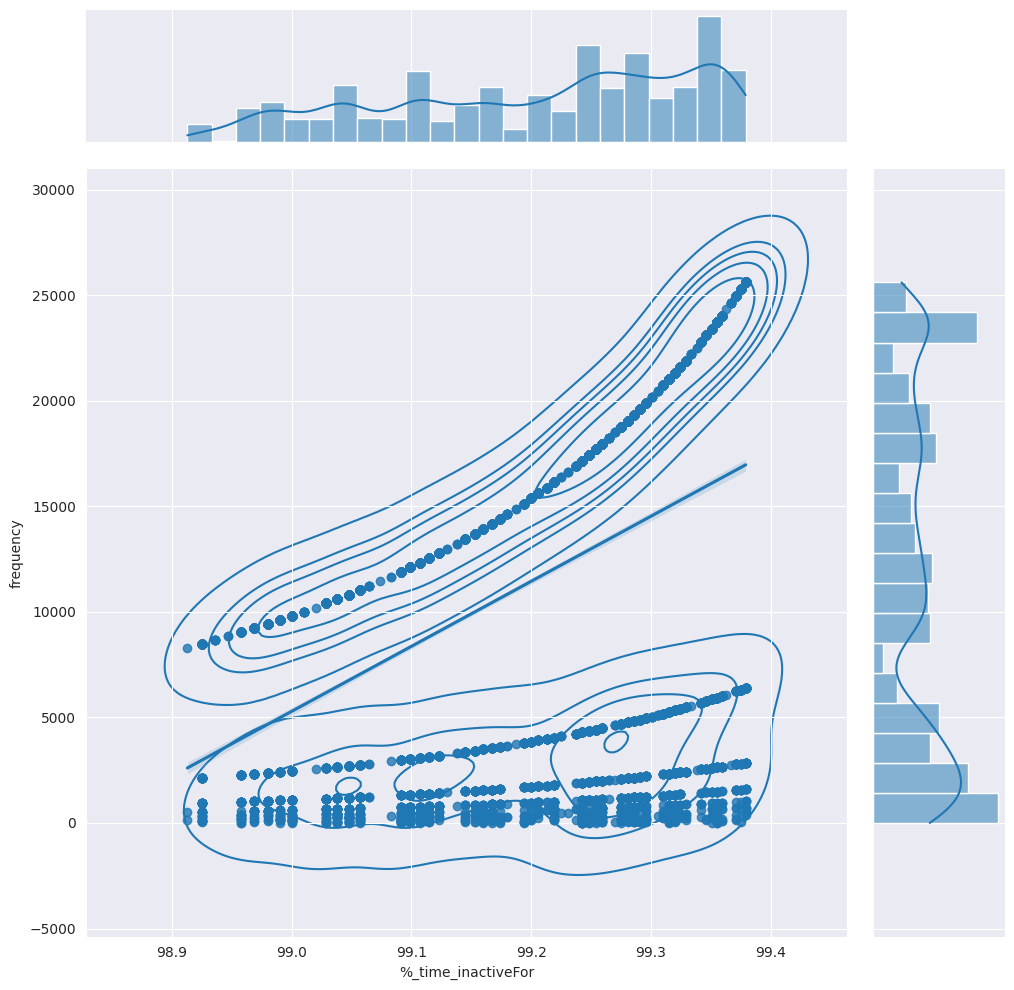

In [25]:
corr, _ = pearsonr(
    use_df_2_for_ds["%_time_inactiveFor"], use_df_2_for_ds["frequency"]
)
jointPlot = (
    sns.jointplot(
        x="%_time_inactiveFor",
        y="frequency",
        data=use_df_2_for_ds,
        kind="reg",
        height=10,
    )
).plot_joint(sns.kdeplot, zorder=0, n_levels=6)

plt.show()

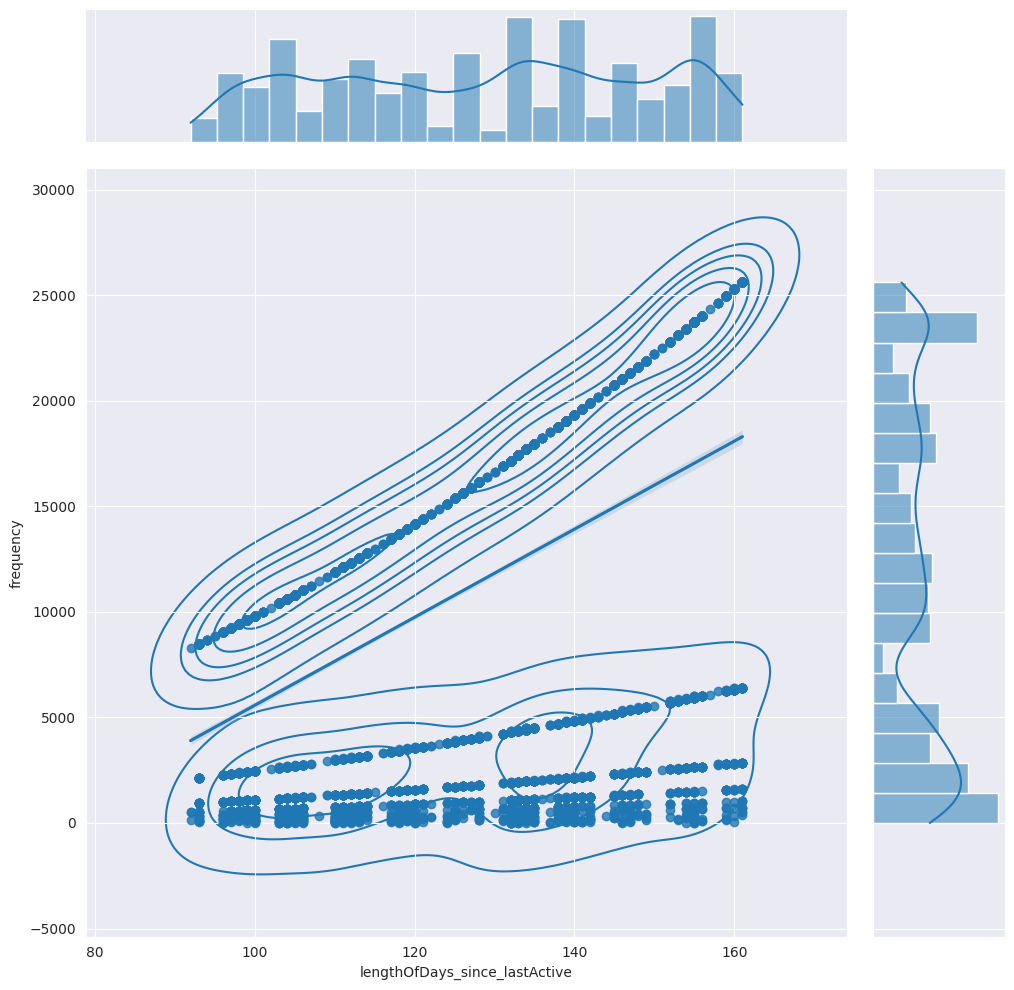

In [26]:
corr, _ = pearsonr(
    use_df_2_for_ds["lengthOfDays_since_lastActive"],
    use_df_2_for_ds["frequency"],
)
jointPlot = (
    sns.jointplot(
        x="lengthOfDays_since_lastActive",
        y="frequency",
        data=use_df_2_for_ds,
        kind="reg",
        height=10,
    )
).plot_joint(sns.kdeplot, zorder=0, n_levels=6)

plt.show()

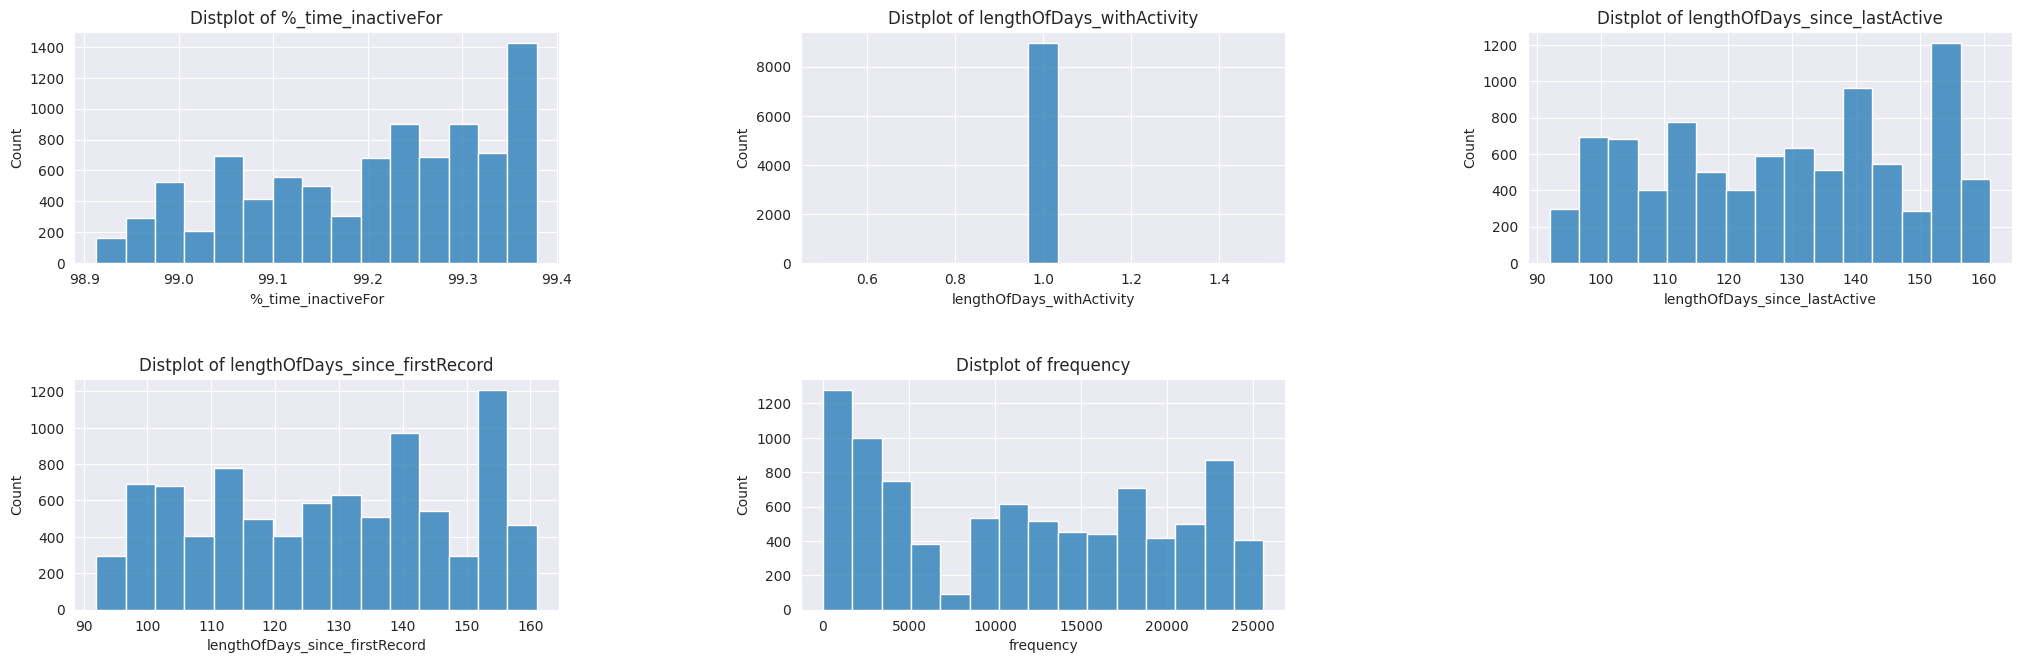

In [27]:
columns = [
    "%_time_inactiveFor",
    "lengthOfDays_withActivity",
    "lengthOfDays_since_lastActive",
    "lengthOfDays_since_firstRecord",
    "frequency",
]


plt.figure(1, figsize=(25, 12))
n = 0
for x in [
    "%_time_inactiveFor",
    "lengthOfDays_withActivity",
    "lengthOfDays_since_lastActive",
    "lengthOfDays_since_firstRecord",
    "frequency",
]:
    n += 1
    plt.subplot(3, 3, n)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    sns.histplot(use_df_2_for_ds[x], bins=15)
    plt.title("Distplot of {}".format(x))
plt.show()

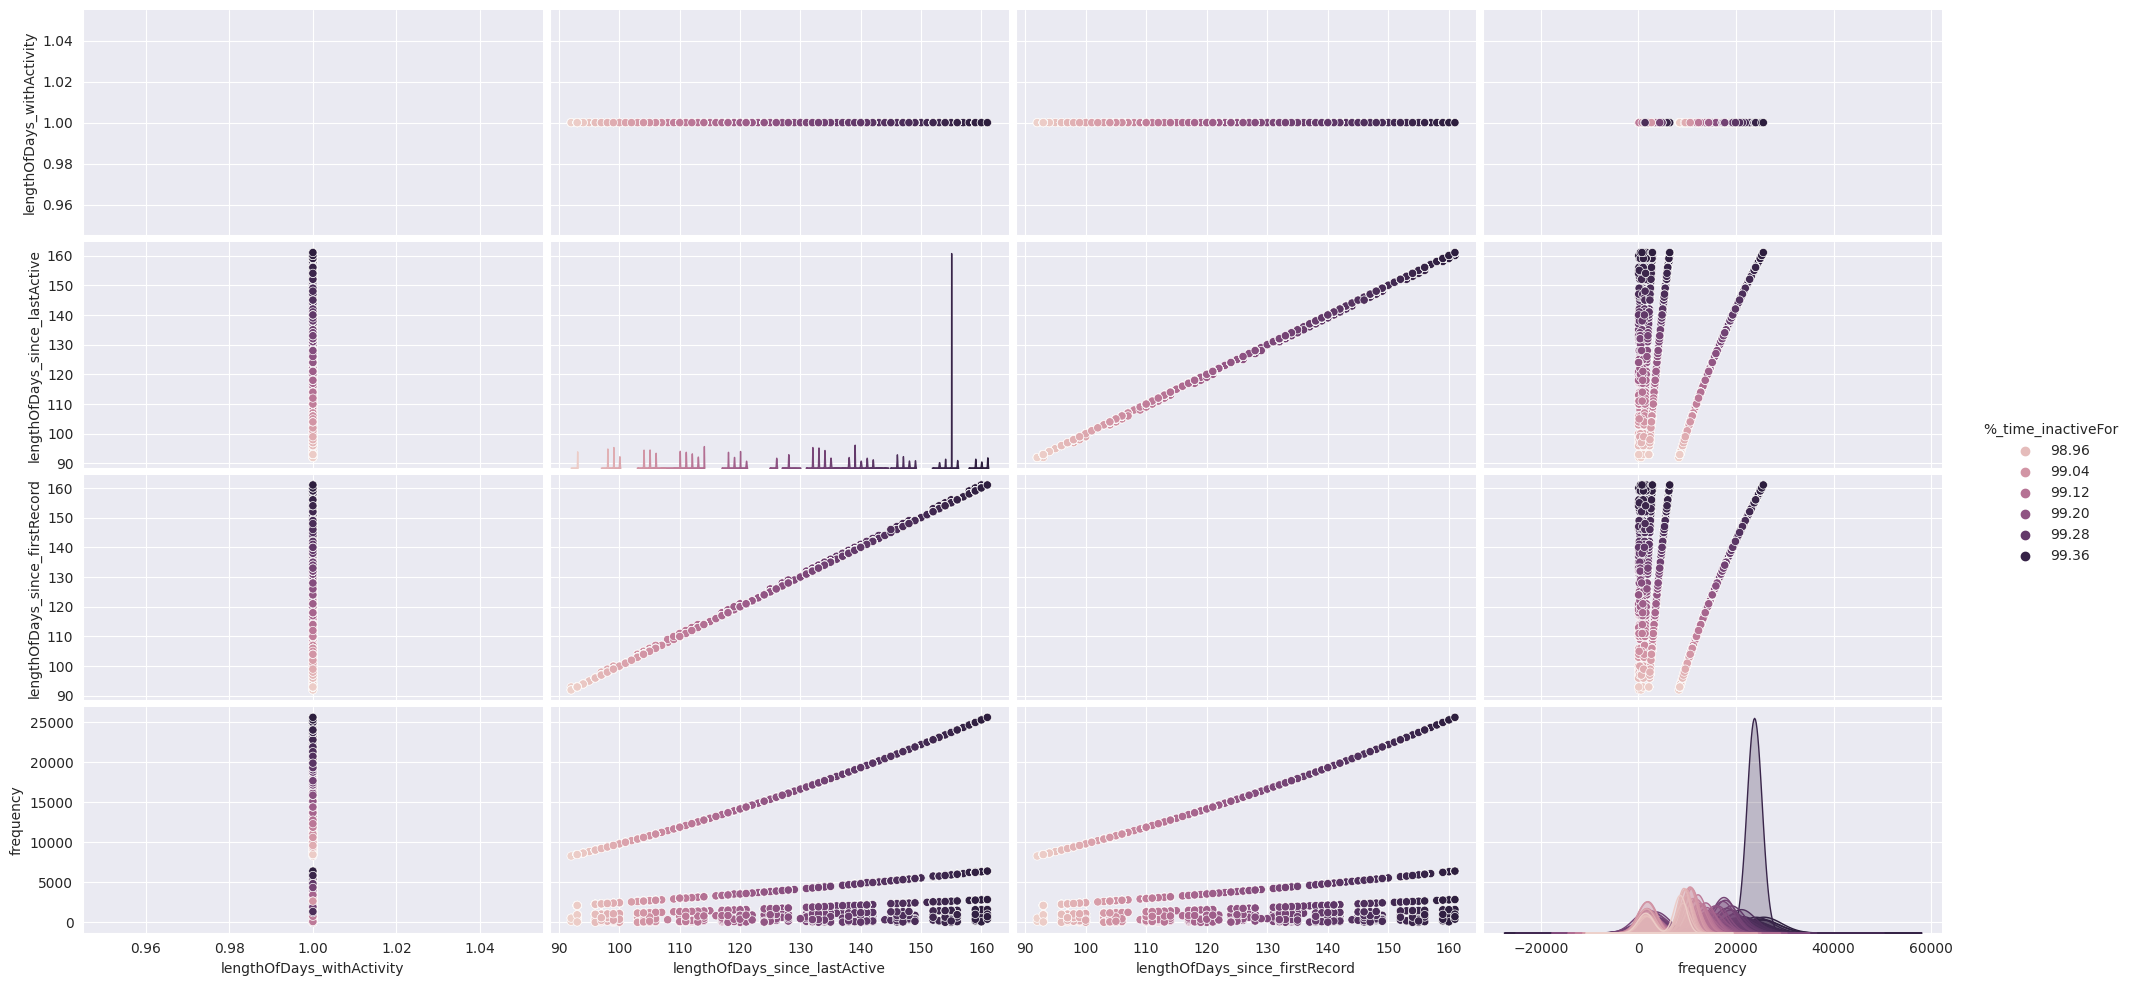

In [28]:
sns.pairplot(use_df_2_for_ds[columns], hue="%_time_inactiveFor", aspect=2)
plt.show()

<p style="color:#008bcb; font-family:Arial; font-size:19px;">5 - Machine Learning Section - Clustering</p>

In [29]:
dscols = [
    "UserId",
    "lengthOfDays_withActivity",
    "frequency",
    "%_time_inactiveFor",
]  #'lengthOfDays_since_lastActive','lengthOfDays_since_firstRecord',

In [30]:
# use clustering analysis on dataframe to determine number of clusters to use
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from scipy.stats import pearsonr
from sklearn.preprocessing import LabelEncoder

In [31]:
use_df_2_for_ds[dscols]

,UserId,lengthOfDays_withActivity,frequency,%_time_inactiveFor
0,aaron14@example.org,1.0,2336.11,99.315
1,aaron14@example.org,1.0,5256.25,99.315
2,aaron14@example.org,1.0,21025.00,99.315
3,aaron14@example.org,1.0,21025.00,99.315
4,aaron14@example.org,1.0,21025.00,99.315
...,...,...,...,...
8955,zthornton@example.net,1.0,1936.00,99.248
8956,zthornton@example.net,1.0,4356.00,99.248
8957,zturner@example.net,1.0,2652.25,99.038
8958,zturner@example.net,1.0,10609.00,99.038


In [32]:
df = use_df_2_for_ds[dscols]
X = df

y = X["UserId"]

In [33]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

X["UserId"] = le.fit_transform(X["UserId"])

y = le.transform(y)

/tmp/ipykernel_2888100/3190033513.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["UserId"] = le.fit_transform(X["UserId"])


In [34]:
# X[y]

In [35]:
# feature scaling
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [36]:
# transform X to dataframe
X = pd.DataFrame(X, columns=dscols)

In [37]:
# kmeans clustering
kmeans = KMeans(n_clusters=7, random_state=0).fit(X)

In [38]:
# check model parameters
kmeans.cluster_centers_

array([[0.24212722, 0.        , 0.59146232, 0.5895118 ],
       [0.77926819, 0.        , 0.74341947, 0.77218968],
       [0.25738325, 0.        , 0.12147185, 0.76558176],
       [0.24989177, 0.        , 0.2207133 , 0.23088219],
       [0.76408154, 0.        , 0.11883535, 0.76630253],
       [0.35971986, 0.        , 0.89066802, 0.917372  ],
       [0.75912349, 0.        , 0.28856287, 0.29353561]])



    The KMeans algorithm clusters data by trying to separate samples in n groups of equal variances, minimizing a criterion known as inertia, or within-cluster sum-of-squares Inertia, or the within-cluster sum of squares criterion, can be recognized as a measure of how internally coherent clusters are.

    The k-means algorithm divides a set of N samples X into K disjoint clusters C, each described by the mean j of the samples in the cluster. The means are commonly called the cluster centroids.

    The K-means algorithm aims to choose centroids that minimize the inertia, or within-cluster sum of squared criterion.

Inertia

    Inertia is not a normalized metric.

    The lower values of inertia are better and zero is optimal.

    But in very high-dimensional spaces, euclidean distances tend to become inflated (this is an instance of curse of dimensionality).

    Running a dimensionality reduction algorithm such as PCA prior to k-means clustering can alleviate this problem and speed up the computations.

    We can calculate model inertia as follows:-




In [39]:
# check model internal consistency
kmeans.inertia_

450.0052929583642



    The lesser the model inertia, the better the model fit.

    We can see that the model has reasonably low inertia. So, this might be a good model fit to the data.



In [40]:
# check quality of model fit
labels = kmeans.labels_

# check how many of the samples were correctly labeled
correct_labels = sum(y == labels)

print(
    "Result: %d out of %d samples were correctly labeled."
    % (correct_labels, y.size)
)

Result: 2 out of 8960 samples were correctly labeled.


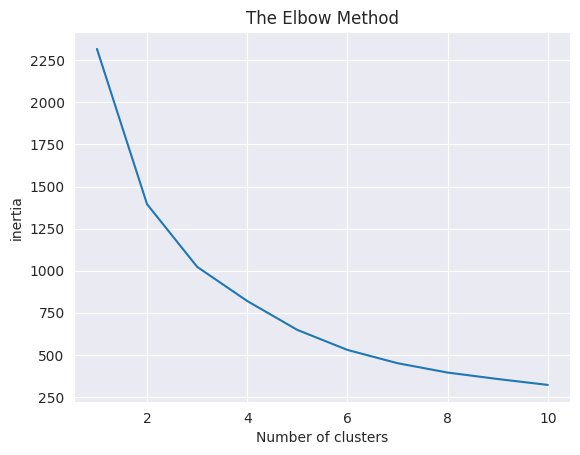

In [41]:
# elbow method to determine optimal number of clusters
from sklearn.cluster import KMeans

cs = []
for i in range(1, 11):
    kmeans = KMeans(
        n_clusters=i, init="k-means++", max_iter=300, n_init=10, random_state=0
    )
    kmeans.fit(X)
    cs.append(kmeans.inertia_)
plt.plot(range(1, 11), cs)
plt.title("The Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("inertia")
plt.show()

In [42]:
# kmeans clustering with optimal number of clusters
kmeans = KMeans(
    n_clusters=8,
    init="k-means++",
    n_init=10,
    max_iter=300,
    tol=0.0001,
    random_state=111,
    algorithm="elkan",
).fit(X)

In [43]:
kmeans.inertia_

394.3804083798106

In [44]:
# check quality of model fit
labels = kmeans.labels_

# check how many of the samples were correctly labeled
correct_labels = sum(y == labels)

print(
    "Result: %d out of %d samples were correctly labeled."
    % (correct_labels, y.size)
)

Result: 4 out of 8960 samples were correctly labeled.


In [45]:
# check how many of the samples were correctly labeled
correct_labels = sum(y == labels)

In [46]:
# show cluster centroids
kmeans.cluster_centers_

array([[0.7462074 , 0.        , 0.44515347, 0.32476924],
       [0.35731553, 0.        , 0.88966421, 0.91653225],
       [0.225484  , 0.        , 0.23334008, 0.22432165],
       [0.72842068, 0.        , 0.07020279, 0.34481007],
       [0.77640104, 0.        , 0.7642274 , 0.7962762 ],
       [0.76004133, 0.        , 0.1245766 , 0.80376431],
       [0.25202602, 0.        , 0.12136055, 0.7665583 ],
       [0.22941926, 0.        , 0.59562777, 0.59560525]])

In [47]:
# Create cluster feature
kmeans = KMeans(n_clusters=6)
X["Cluster"] = kmeans.fit_predict(X)
X["Cluster"] = X["Cluster"].astype("category")

X

,UserId,lengthOfDays_withActivity,frequency,%_time_inactiveFor,Cluster
0,0.000000,0.0,0.091250,0.862661,5
1,0.000000,0.0,0.205318,0.862661,5
2,0.000000,0.0,0.821288,0.862661,4
3,0.000000,0.0,0.821288,0.862661,4
4,0.000000,0.0,0.821288,0.862661,4
...,...,...,...,...,...
8955,0.999558,0.0,0.075620,0.718884,1
8956,0.999558,0.0,0.170152,0.718884,1
8957,0.999779,0.0,0.103599,0.268240,2
8958,0.999779,0.0,0.414411,0.268240,2


In [48]:
# # columns of interest
# cols = ['Id', 'CreationTime', 'CreationTimeUTC', 'RecordType', 'Operation', 'OrganizationId', 'UserType', 'UserKey', 'Workload', 'UserId', 'ClientIP', 'UserAgent', 'Activity', 'ItemName', 'WorkSpaceName', 'DashboardName', 'DatasetName', 'ReportName',
# 'WorkspaceId', 'ObjectId', 'DashboardId', 'DatasetId', 'ReportId', 'OrgAppPermission', 'CapacityId', 'CapacityName', 'AppName', 'IsSuccess', 'ReportType', 'RequestId', 'ActivityId', 'AppReportId', 'DistributionMethod', 'ConsumptionMethod', 'RetrieveDate']

In [49]:
algorithm = KMeans(
    n_clusters=4,
    init="k-means++",
    n_init=10,
    max_iter=300,
    tol=0.0001,
    random_state=111,
    algorithm="elkan",
)
algorithm.fit(X)
labels1 = algorithm.labels_
centroids1 = algorithm.cluster_centers_

In [50]:
centroids1

array([[7.53279853e-01, 0.00000000e+00, 2.13633070e-01, 4.85585191e-01,
        1.58801357e+00],
       [2.59176775e-01, 0.00000000e+00, 1.21170515e-01, 7.66560676e-01,
        5.00000000e+00],
       [2.33508427e-01, 0.00000000e+00, 3.17900640e-01, 3.09310226e-01,
        9.32587341e-15],
       [5.10510198e-01, 0.00000000e+00, 7.91214451e-01, 8.19267765e-01,
        3.57022235e+00]])

In [51]:
# fileToSave = load_raw_files(allcsv_windows_glob_glob)

In [52]:
# # function to write csv file to disk
# def save_df_to_disk(df, path) -> pd.DataFrame:
#     """
#
#     :param df:
#     :param path:
#     :return:
#     """
#     df.to_csv(path, index=False)
#     return df

In [53]:
# save_df_to_disk(diff_in_days, r'C:\Users\sibitoye\Documents\PBI_AuditLog_Final_Python_Output\PBI_Clean_July_August_2022.csv')

In [54]:
# export use_df_2_for_ds to csv
# use_df_2.to_csv(r'C:\Users\sibitoye\Documents\PBI_AuditLog_Final_Python_Output\PBI_Clean_July_August_2022.csv', index=False)

In [55]:
# # function to write csv file to disk
# def save_df_to_disk(df, path) -> pd.DataFrame:
#     """
#
#     :param df:
#     :param path:
#     :return:
#     """
#     df.to_csv(path, index=False)
#     return df

# UNSUPERVISED MACHINE LEARNING EXPERIMENT - K-MEANS CLUSTERING

In [56]:
# set up the dataframe and fit it to kmeans clustering algorithm

X1 = use_df_2_for_ds[["frequency", "%_time_inactiveFor"]].iloc[:, :].values
inertia = []
for n in range(1, 15):
    algorithm = KMeans(
        n_clusters=n,
        init="k-means++",
        n_init=10,
        max_iter=300,
        tol=0.0001,
        random_state=111,
        algorithm="lloyd",
    )
    algorithm.fit(X1)
    inertia.append(algorithm.inertia_)

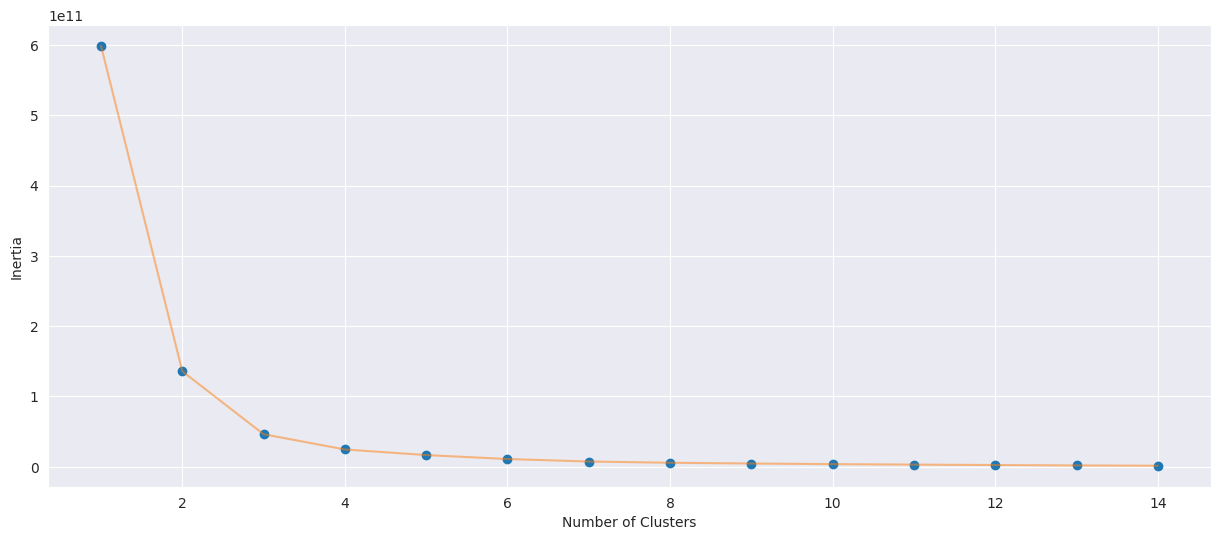

In [57]:
# check the optimum number of clusters to give the best model performance
plt.figure(1, figsize=(15, 6))
plt.plot(np.arange(1, 15), inertia, "o")
plt.plot(np.arange(1, 15), inertia, "-", alpha=0.5)
plt.xlabel("Number of Clusters"), plt.ylabel("Inertia")
plt.show()

# UNSUPERVISED MACHINE LEARNING EXPERIMENT WITH 4 CLUSTERS

In [58]:
algorithm = KMeans(
    n_clusters=4,
    init="k-means++",
    n_init=10,
    max_iter=300,
    tol=0.0001,
    random_state=111,
    algorithm="elkan",
)
algorithm.fit(X1)
labels1 = algorithm.labels_
centroids1 = algorithm.cluster_centers_

In [59]:
h = 0.02
x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])

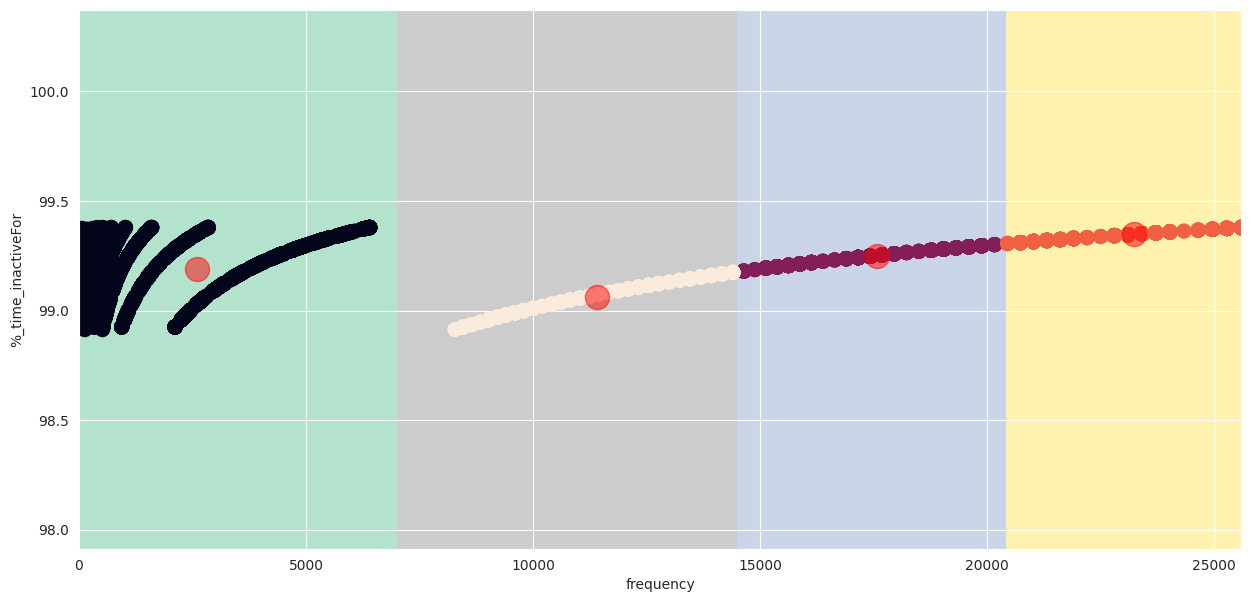

In [60]:
plt.figure(1, figsize=(15, 7))
plt.clf()
Z = Z.reshape(xx.shape)
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Pastel2,
    aspect="auto",
    origin="lower",
)

plt.scatter(x="frequency", y="%_time_inactiveFor", data=df, c=labels1, s=100)
plt.scatter(x=centroids1[:, 0], y=centroids1[:, 1], s=300, c="red", alpha=0.5)
plt.ylabel("%_time_inactiveFor"), plt.xlabel("frequency")
plt.show()

In [61]:
algorithm.inertia_

24519553077.45806

# UNSUPERVISED MACHINE LEARNING EXPERIMENT WITH 5 CLUSTERS

In [62]:
algorithm = KMeans(
    n_clusters=5,
    init="k-means++",
    n_init=10,
    max_iter=300,
    tol=0.0001,
    random_state=111,
    algorithm="lloyd",
)
algorithm.fit(X1)
labels1 = algorithm.labels_
centroids1 = algorithm.cluster_centers_

In [63]:
h = 0.02
x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])

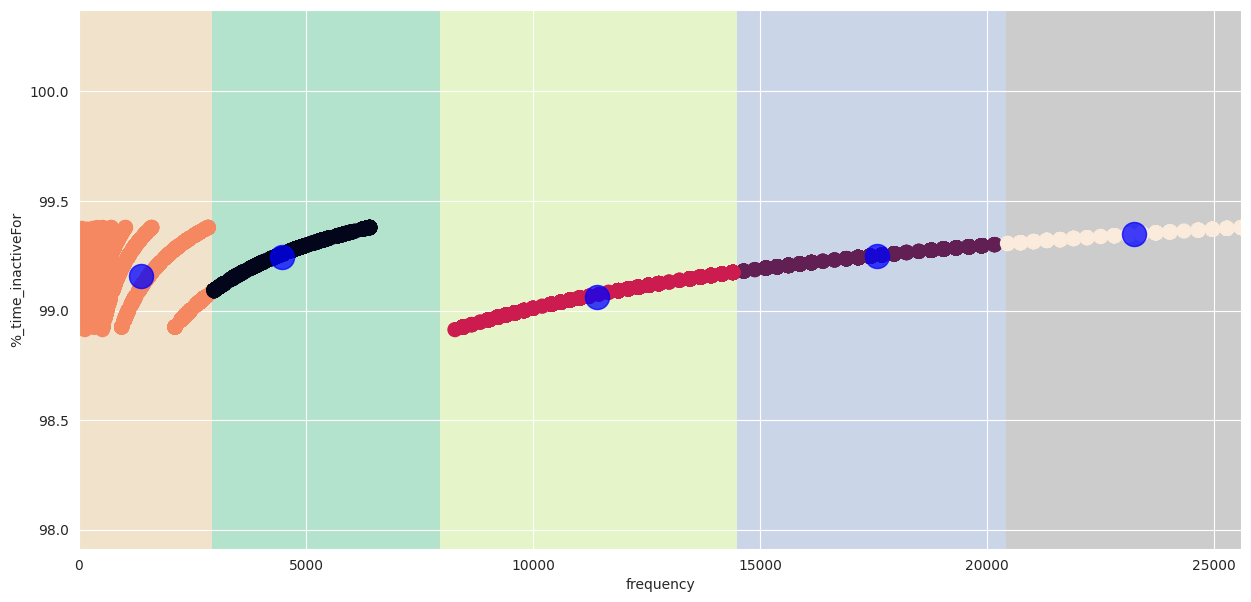

In [64]:
plt.figure(1, figsize=(15, 7))
plt.clf()
Z = Z.reshape(xx.shape)
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Pastel2,
    aspect="auto",
    origin="lower",
)

plt.scatter(x="frequency", y="%_time_inactiveFor", data=df, c=labels1, s=100)
plt.scatter(
    x=centroids1[:, 0], y=centroids1[:, 1], s=300, c="blue", alpha=0.75
)
plt.ylabel("%_time_inactiveFor"), plt.xlabel("frequency")
plt.show()

In [65]:
algorithm.inertia_

16543157012.935974

# 3 Dimensional Clustering

In [66]:
X3 = (
    df[["frequency", "%_time_inactiveFor", "lengthOfDays_withActivity"]]
    .iloc[:, :]
    .values
)
inertia = []
for n in range(1, 11):
    algorithm = KMeans(
        n_clusters=n,
        init="k-means++",
        n_init=10,
        max_iter=300,
        tol=0.0001,
        random_state=111,
        algorithm="lloyd",
    )
    algorithm.fit(X3)
    inertia.append(algorithm.inertia_)

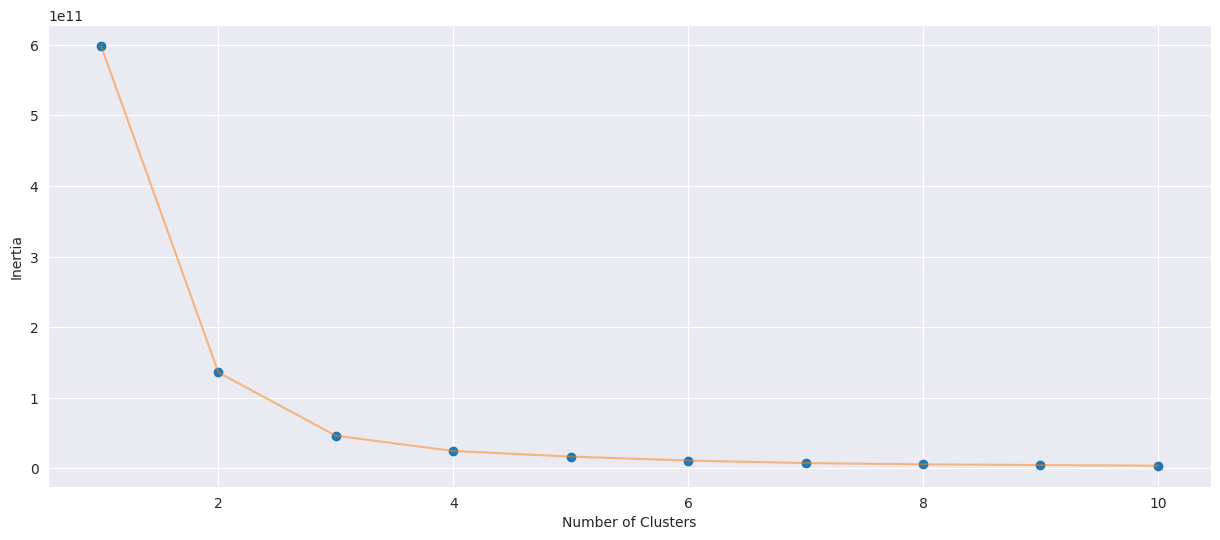

In [67]:
plt.figure(1, figsize=(15, 6))
plt.plot(np.arange(1, 11), inertia, "o")
plt.plot(np.arange(1, 11), inertia, "-", alpha=0.5)
plt.xlabel("Number of Clusters"), plt.ylabel("Inertia")
plt.show()

In [68]:
algorithm = KMeans(
    n_clusters=7,
    init="k-means++",
    n_init=10,
    max_iter=300,
    tol=0.0001,
    random_state=111,
    algorithm="lloyd",
)
algorithm.fit(X3)
labels3 = algorithm.labels_
centroids3 = algorithm.cluster_centers_

y_kmeans = algorithm.fit_predict(X3)

In [69]:
# check quality of model fit
algorithm.inertia_

7389060721.642349

In [70]:
df["cluster"] = pd.DataFrame(y_kmeans)
df.head()

/tmp/ipykernel_2888100/1414252177.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cluster"] = pd.DataFrame(y_kmeans)


,UserId,lengthOfDays_withActivity,frequency,%_time_inactiveFor,cluster
0,0,1.0,2336.11,99.315,0
1,0,1.0,5256.25,99.315,4
2,0,1.0,21025.00,99.315,5
3,0,1.0,21025.00,99.315,5
4,0,1.0,21025.00,99.315,5


In [71]:
# import plotly as py
# import plotly.graph_objs as go

# trace1 = go.Scatter3d(
#     x= df['frequency'],
#     y= df['lengthOfDays_withActivity'],
#     z= df['%_time_inactiveFor'],
#     mode='markers',
#      marker=dict(
#         color = df['cluster'],
#         size= 2,
#         line=dict(
#             color= df['cluster'],
#             width= 10
#         ),
#         opacity=0.8
#      )
# )
# data = [trace1]
# layout = go.Layout(
#     title= 'Clusters wrt frequency, lengthOfDays and %_time_inactiveFor',
#     scene = dict(
#             xaxis = dict(title  = 'frequency'),
#             yaxis = dict(title  = 'lengthOfDays'),
#             zaxis = dict(title  = '%_time_inactiveFor')
#         )
# )
# fig = go.Figure(data=data, layout=layout)
# py.offline.iplot(fig)

In [72]:
use_df_2_for_ds["cluster"] = pd.DataFrame(y_kmeans)
# use_df_2_for_ds.head(20)

In [73]:
use_df_2_for_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
count,8960.0,2.215067,7.027274,1.000,1.000,1.000,2.000,418.000
lengthOfDays_withActivity,8960.0,1.000000,0.000000,1.000,1.000,1.000,1.000,1.000
lengthOfDays_since_lastActive,8960.0,128.528125,19.889170,92.000,111.000,132.000,146.000,161.000
lengthOfDays_since_firstRecord,8960.0,128.545089,19.892169,92.000,111.000,132.000,146.000,161.000
frequency,8960.0,11521.568377,8175.893039,0.130,3192.250,11025.000,18769.000,25600.000
%_time_inactiveFor,8960.0,99.202401,0.128654,98.913,99.099,99.242,99.315,99.379
cluster,8960.0,2.656027,2.051842,0.000,1.000,3.000,4.000,6.000


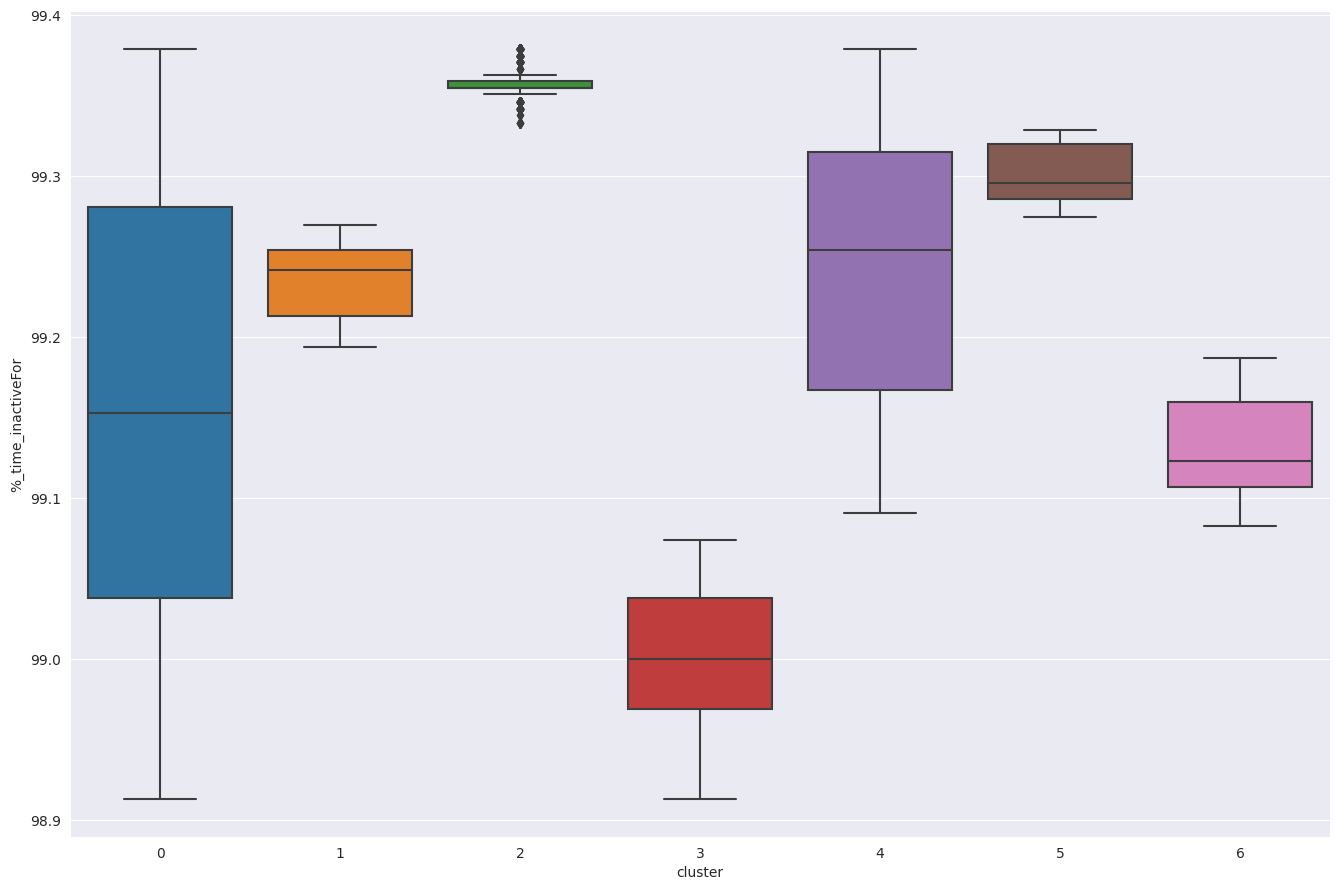

In [74]:
# plot distribution of clusters
sns.catplot(
    x="cluster",
    y="%_time_inactiveFor",
    data=use_df_2_for_ds,
    kind="box",
    aspect=1.5,
    height=9,
)

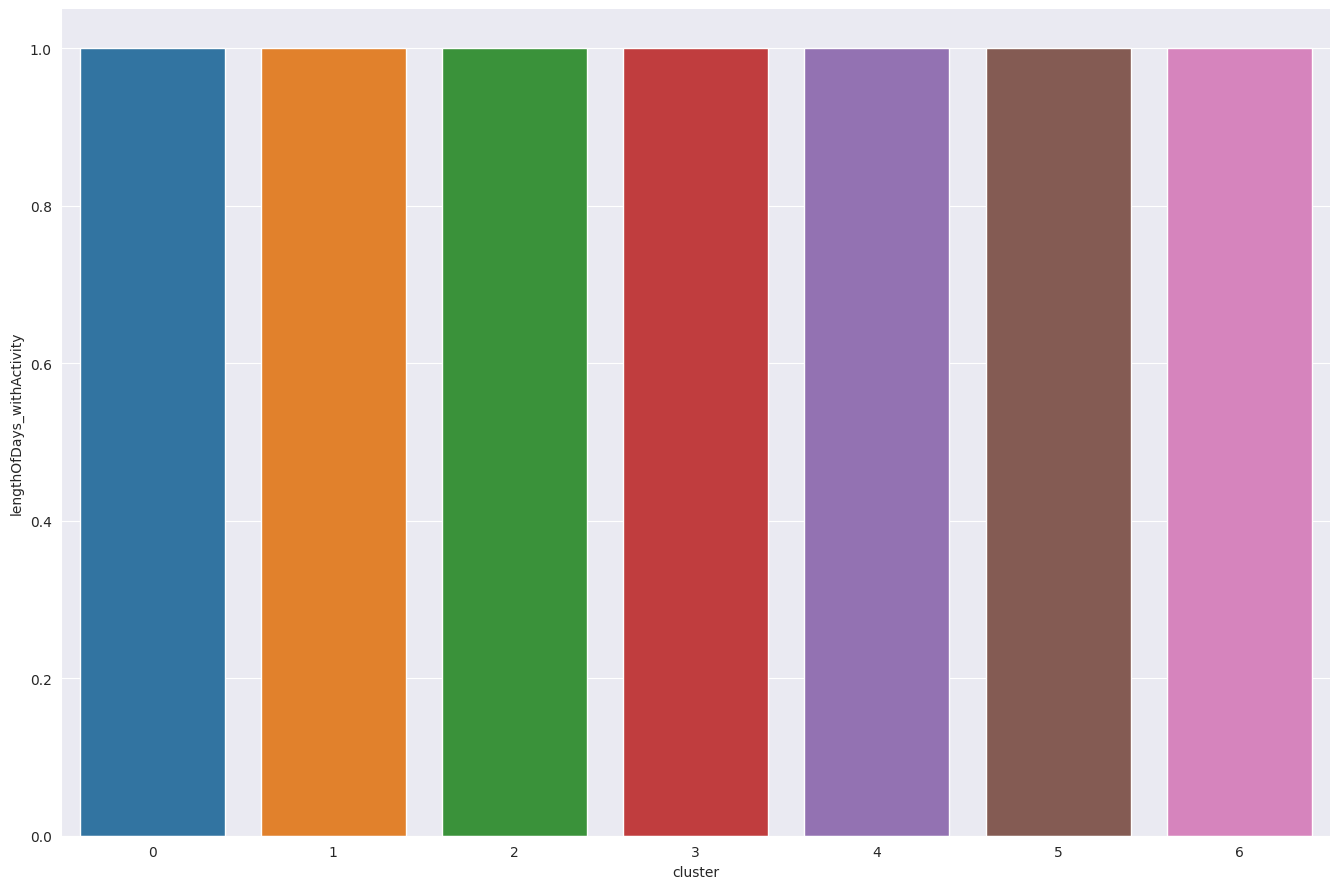

In [75]:
# plot distribution of clusters
sns.catplot(
    x="cluster",
    y="lengthOfDays_withActivity",
    data=use_df_2_for_ds,
    kind="bar",
    aspect=1.5,
    height=9,
)

# -> we can see that the clusters are not very well separated
# -> people in cluster 1 and 5 have more time with activity than people in cluster 2 and 3
# -> people in cluster 2 and 3 are neutral compared to people in cluster 1 and 5 AND cluster 4, 6 and 0
# -> so it is easy to conclude that cluster 1 and 5 are the most active people i.e. Great!
# -> clusters 4, 6 and 0 are the least active people i.e. Not Great!
# -> clusters 2 and 3 are neutral people i.e. Neutral!

/tmp/ipykernel_2888100/3960284949.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.clustermap(use_df_2.corr(), annot=True, cmap="coolwarm", figsize=(20, 15))


ValueError: The condensed distance matrix must contain only finite values.

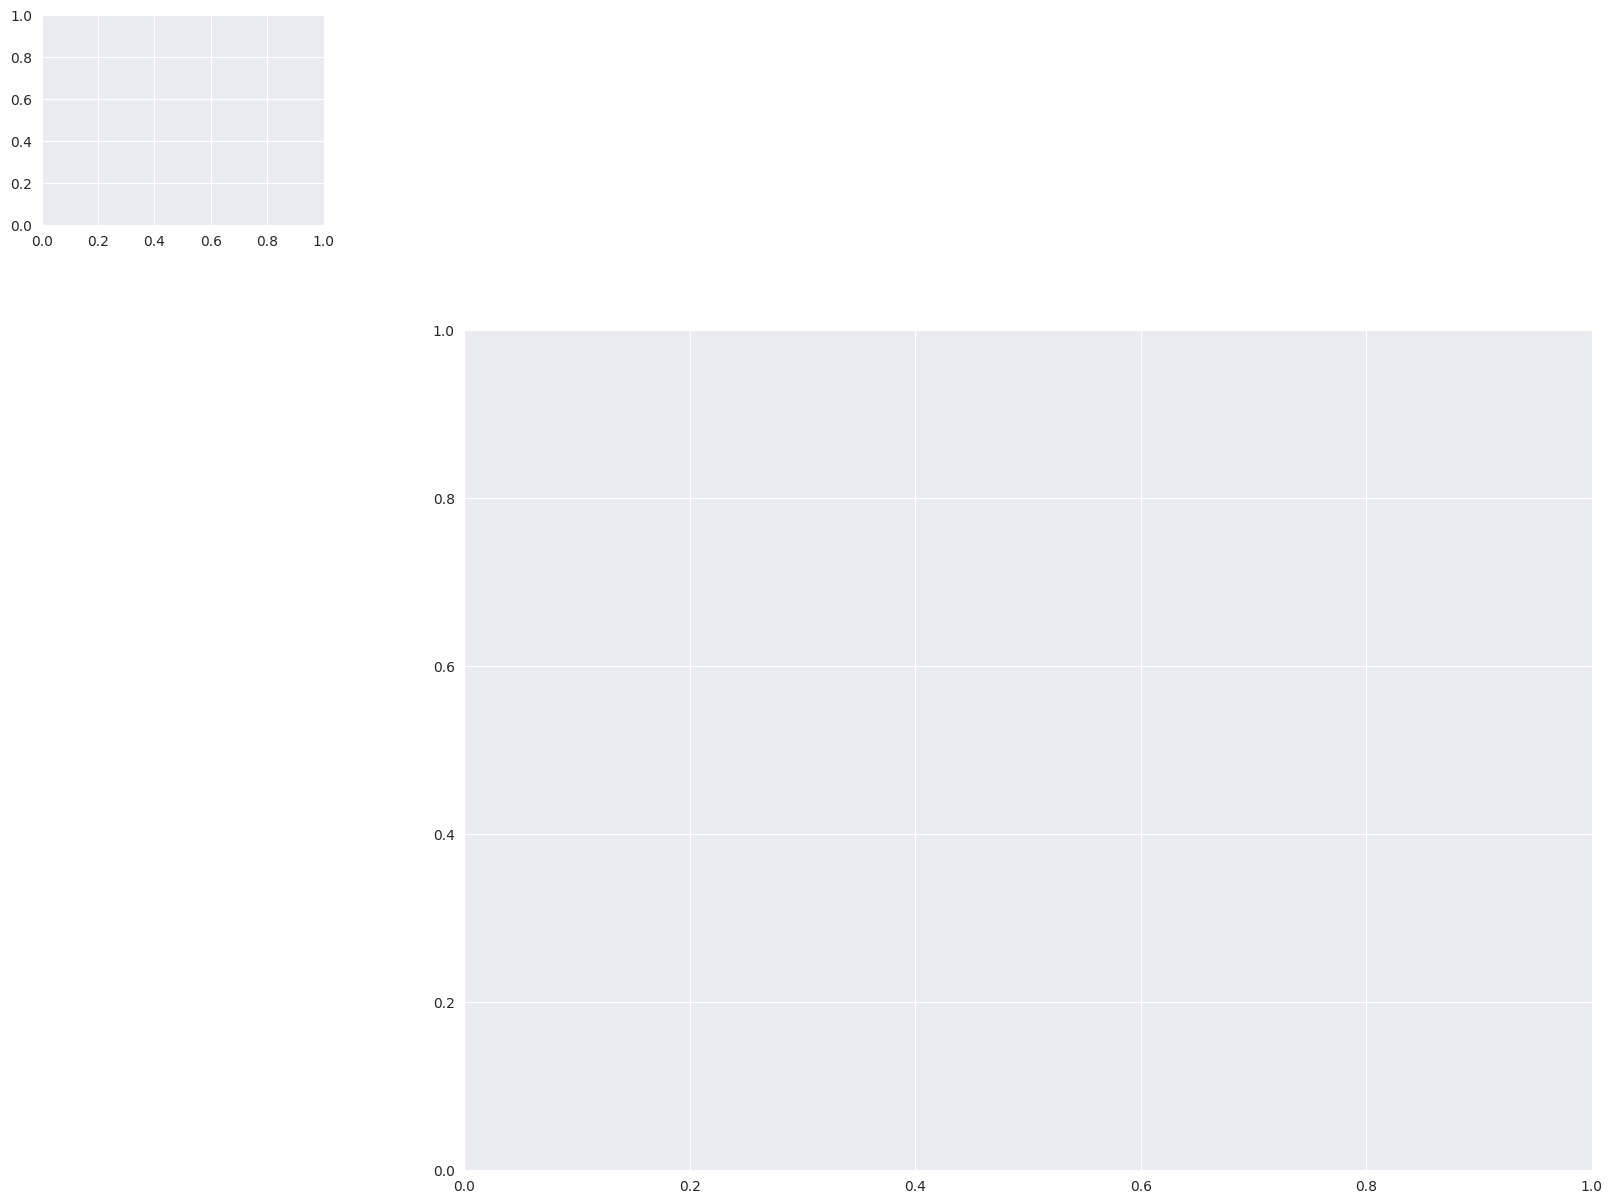

In [76]:
# plot seaborn clustermap
sns.clustermap(use_df_2.corr(), annot=True, cmap="coolwarm", figsize=(20, 15))

<p style="color:#008bcb; font-family:Arial; font-size:19px;">6 - Export Final Output </p>

In [78]:
# divide customers into 6 segments based on outcome of clustering analysis
def four_quad_segment(use_df_2):
    """
    This function takes in a dataframe and returns a dataframe with a new column.
    The new column is a segment based on the frequency and %_time_inactiveFor.

    :param use_df_2: df
    :return: df

    """
    if use_df_2["frequency"] <= 30 and use_df_2["%_time_inactiveFor"] <= 65:
        return "Great - Good Frequency, Good Recency"
    elif use_df_2["frequency"] <= 30 and use_df_2["%_time_inactiveFor"] > 65:
        return "Good - Good Frequency, Bad Recency"
    elif use_df_2["frequency"] > 30 and use_df_2["%_time_inactiveFor"] <= 65:
        return "Fair - Bad Frequency, Good Recency"
    else:
        return "Investigate - Bad Frequency, Bad Recency"


use_df_2["segment"] = use_df_2.apply(four_quad_segment, axis=1)

In [79]:
use_df_2.head()

,UserId,UserKey,WorkSpaceName,WorkspaceId,ReportName,ReportId,Activity,count,min,max,lengthOfDays_withActivity,lengthOfDays_since_lastActive,lengthOfDays_since_firstRecord,frequency,%_time_inactiveFor,segment
0,aaron14@example.org,100300009C37523D,kacctydrvl,e1b945e5-9e7d-40f7-a037-8f8d1e5cde79,avezeywxoy,44cda3d5-77a5-45e9-b596-7def26fdab6d,ViewReport,3,2022-07-21 14:33:10+00:00,2022-07-21 15:32:03+00:00,1.0,146.0,146.0,2336.11,99.315,"Investigate - Bad Frequency, Bad Recency"
1,aaron14@example.org,100300009C37523D,kacctydrvl,e1b945e5-9e7d-40f7-a037-8f8d1e5cde79,hbtohnbqhf,4d85e424-9af0-4a7f-b874-5f410407f507,ViewReport,2,2022-07-21 07:22:06+00:00,2022-07-21 14:54:07+00:00,1.0,146.0,146.0,5256.25,99.315,"Investigate - Bad Frequency, Bad Recency"
2,aaron14@example.org,100300009C37523D,kacctydrvl,e1b945e5-9e7d-40f7-a037-8f8d1e5cde79,mvwgtbbwrh,d8aed01d-d910-4baa-a59e-fb2f2c5047ec,ViewReport,1,2022-07-21 14:32:29+00:00,2022-07-21 14:32:29+00:00,1.0,146.0,146.0,21025.00,99.315,"Investigate - Bad Frequency, Bad Recency"
3,aaron14@example.org,100300009C37523D,kacctydrvl,e1b945e5-9e7d-40f7-a037-8f8d1e5cde79,vtlkbzpylz,e621218e-1abf-453a-9856-28900a5fb0fc,ViewReport,1,2022-07-21 13:48:27+00:00,2022-07-21 13:48:27+00:00,1.0,146.0,146.0,21025.00,99.315,"Investigate - Bad Frequency, Bad Recency"
4,aaron14@example.org,100300009C37523D,kacctydrvl,e1b945e5-9e7d-40f7-a037-8f8d1e5cde79,yatgdqzkvq,80ffdcac-8e29-421b-a1b3-b06d7ac6dc1c,ViewReport,1,2022-07-21 11:38:31+00:00,2022-07-21 11:38:31+00:00,1.0,146.0,146.0,21025.00,99.315,"Investigate - Bad Frequency, Bad Recency"


In [ ]:
# use_df_2.to_csv(r'/home/sanmi/OlaJay/SimpleAnonlify/PBI_Clean_July_August_2022.csv', index=False)